# Unsupervised Clustering - Student Segmentation

## Objective
Segment students into distinct learning personas using K-Means clustering based on behavioural features.

## CRISP-DM Stage
Modelling and Evaluation

## Methods
- Feature selection and standardisation
- Elbow Method for optimal k determination
- Silhouette Score analysis
- K-Means clustering
- PCA visualisation
- Cluster profiling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully')
print('=' * 80)

All libraries imported successfully


## Section 1: Load and Prepare Clustering Features

Create 4 simple, interpretable features for student segmentation.

In [10]:
print('\\n' + '=' * 80)
print('CLUSTERING: BEHAVIORAL FEATURE PREPARATION')
print('=' * 80)

df_encoded = pd.read_pickle('../2_Outputs/df_encoded_full.pkl')

# Create 4 purely behavioral features (NO performance/grade data)
print('Creating BEHAVIORAL-ONLY student engagement features...\\n')
print('⚠️  NOTE: These features capture behavior WITHOUT knowing student grades')
print('This allows us to discover behavioral personas independently from outcomes.\\n')

df_features = df_encoded.copy()

# Feature 1: Engagement Level (how active is the student?)
df_features['total_clicks_norm'] = (
    df_encoded['total_clicks'] / (df_encoded['total_clicks'].quantile(0.95) + 1e-6)
).clip(0, 1)  # Normalise to 0-1, cap at top 5%

# Feature 2: Activity Duration (do they engage over long periods or burn out?)
df_features['days_active_norm'] = (
    df_encoded['days_active'] / (df_encoded['days_active'].max() + 1e-6)
)  # Proportion of course days active

# Feature 3: Submission Delay (do they procrastinate or submit early?)
df_features['submit_delay_norm'] = (
    df_encoded['submit_delay_mean'] / (df_encoded['submit_delay_mean'].quantile(0.95) + 1e-6)
).clip(0, 1)  # Normalise; high = high procrastination

# Feature 4: Late Submission Behavior (do they frequently submit late?)
# Using num_late_submissions instead of late_clicks (which was all zeros)
df_features['num_late_subs_norm'] = (
    df_encoded['num_late_submissions'] / (df_encoded['num_late_submissions'].quantile(0.95) + 1e-6)
).clip(0, 1)  # Normalise; high = frequent late submissions

# Select only the 4 purely BEHAVIORAL features
clustering_features = ['total_clicks_norm', 'days_active_norm', 'submit_delay_norm', 'num_late_subs_norm']

print(f'Behavioral Clustering Features ({len(clustering_features)}):')
print('\\n1. total_clicks_norm (Engagement): How much did they click/interact?')
print('2. days_active_norm (Activity Duration): Over how many days were they active?')
print('3. submit_delay_norm (Procrastination): How long did they delay submissions?')
print('4. num_late_subs_norm (Late Submissions): How many submissions were late?')

print(f'\\nFeature Statistics:')
for feat in clustering_features:
    print(f'  • {feat}: Min={df_features[feat].min():.3f}, Max={df_features[feat].max():.3f}, Mean={df_features[feat].mean():.3f}')

X_clustering = df_features[clustering_features].fillna(0)

print(f'\\nClustering dataset shape: {X_clustering.shape}')
print(f'\\nFeature Summary:')
print(X_clustering.describe())

scaler = StandardScaler()
X_clustering_scaled = scaler.fit_transform(X_clustering)

print(f'\\nScaled features shape: {X_clustering_scaled.shape}')
print('\\n✓ Behavioral features ready for clustering...')
print('These clusters will reveal behavioral personas WITHOUT grade bias!')

\n================================================================================
CLUSTERING: BEHAVIORAL FEATURE PREPARATION
Creating BEHAVIORAL-ONLY student engagement features...\n
⚠️  NOTE: These features capture behavior WITHOUT knowing student grades
This allows us to discover behavioral personas independently from outcomes.\n
Behavioral Clustering Features (4):
\n1. total_clicks_norm (Engagement): How much did they click/interact?
2. days_active_norm (Activity Duration): Over how many days were they active?
3. submit_delay_norm (Procrastination): How long did they delay submissions?
4. num_late_subs_norm (Late Submissions): How many submissions were late?
\nFeature Statistics:
  • total_clicks_norm: Min=0.000, Max=1.000, Mean=0.243
  • days_active_norm: Min=0.000, Max=1.000, Mean=0.106
  • submit_delay_norm: Min=0.000, Max=1.000, Mean=0.155
  • num_late_subs_norm: Min=0.000, Max=1.000, Mean=0.240
\nClustering dataset shape: (32593, 4)
\nFeature Summary:
       total_clicks_norm 

## Section 2: Determine Optimal Clusters - Elbow Method

Identify optimal number of clusters by analysing within-cluster sum of squares.


ELBOW METHOD FOR OPTIMAL K
k=2: Inertia = 51669.0273
k=3: Inertia = 27398.1758
k=4: Inertia = 18467.7734
k=5: Inertia = 14798.2891
k=6: Inertia = 11758.2617
k=7: Inertia = 10122.3926
k=8: Inertia = 8696.1904
k=9: Inertia = 7735.1157
k=10: Inertia = 6925.7461


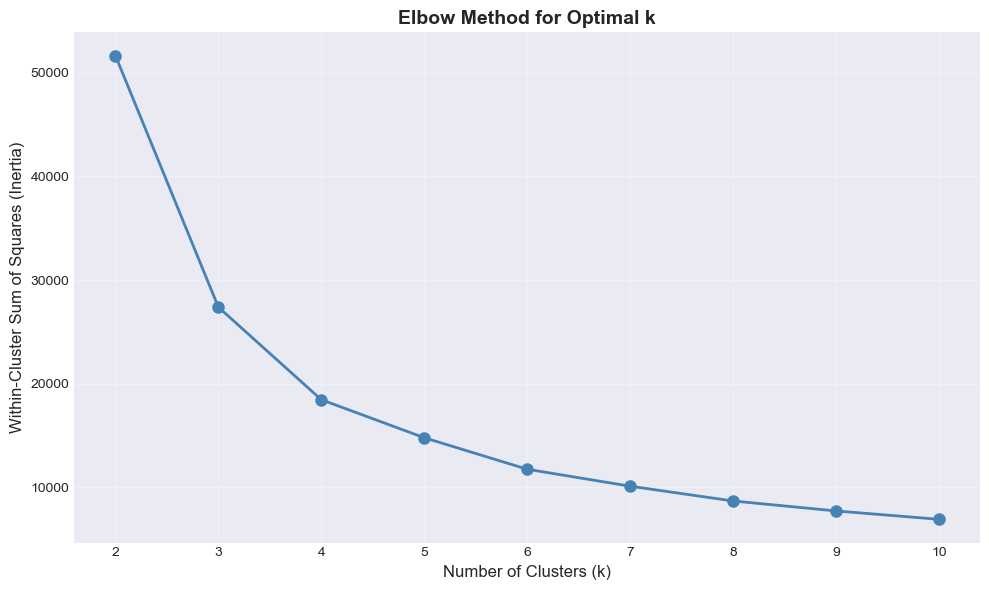

In [3]:
print('\n' + '=' * 80)
print('ELBOW METHOD FOR OPTIMAL K')
print('=' * 80)

inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering_scaled)
    inertias.append(kmeans.inertia_)
    print(f'k={k}: Inertia = {kmeans.inertia_:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='-', linewidth=2, markersize=8, color='steelblue')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

## Section 3: Determine Optimal Clusters - Silhouette Score

Evaluate cluster quality using Silhouette Score analysis.


SILHOUETTE SCORE FOR OPTIMAL K
k=2: Silhouette Score = 0.5341
k=3: Silhouette Score = 0.5695
k=4: Silhouette Score = 0.5337
k=5: Silhouette Score = 0.5318
k=6: Silhouette Score = 0.5122
k=7: Silhouette Score = 0.5005
k=8: Silhouette Score = 0.5113
k=9: Silhouette Score = 0.4891
k=10: Silhouette Score = 0.4892

Optimal k (based on Silhouette Score): 3


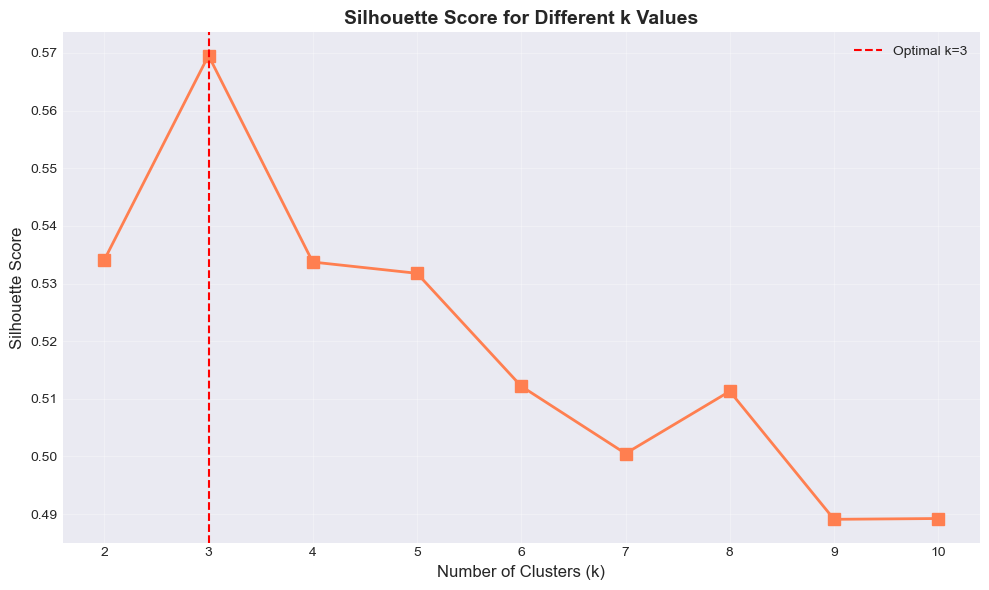


Selected k: 5


In [ ]:
print('\n' + '=' * 80)
print('SILHOUETTE SCORE FOR OPTIMAL K')
print('=' * 80)

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_clustering_scaled)
    silhouette_avg = silhouette_score(X_clustering_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'k={k}: Silhouette Score = {silhouette_avg:.4f}')

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f'\nOptimal k (based on Silhouette Score): {optimal_k_silhouette}')

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='s', linestyle='-', linewidth=2, markersize=8, color='coral')
plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--', label=f'Optimal k={optimal_k_silhouette}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score for Different k Values', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.legend()
plt.tight_layout()
plt.show()

## Section 4: K-Means Clustering

Implement K-Means with optimal number of clusters.

In [11]:
print('\n' + '=' * 80)
print('K-MEANS CLUSTERING')
print('=' * 80)

optimal_k = 3 # Update based on silhouette score

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_clustering_scaled)

df_encoded['cluster'] = cluster_labels

print(f'K-Means converged in {kmeans_final.n_iter_} iterations')
print(f'\nCluster Distribution:')
print(df_encoded['cluster'].value_counts().sort_index())

silhouette_avg = silhouette_score(X_clustering_scaled, cluster_labels)
print(f'\nSilhouette Score (final model): {silhouette_avg:.4f}')

sample_silhouette_values = silhouette_samples(X_clustering_scaled, cluster_labels)
print(f'Average sample Silhouette Value: {sample_silhouette_values.mean():.4f}')


K-MEANS CLUSTERING
K-Means converged in 6 iterations

Cluster Distribution:
cluster
0    18036
1     8716
2     5841
Name: count, dtype: int64

Silhouette Score (final model): 0.5073
Average sample Silhouette Value: 0.5073


## Section 5: PCA Visualisation

Reduce dimensions to 2D for cluster visualisation.


PCA DIMENSIONALITY REDUCTION
PCA Explained Variance Ratio: [0.65116036 0.3260909 ]
Total Variance Explained: 0.9773


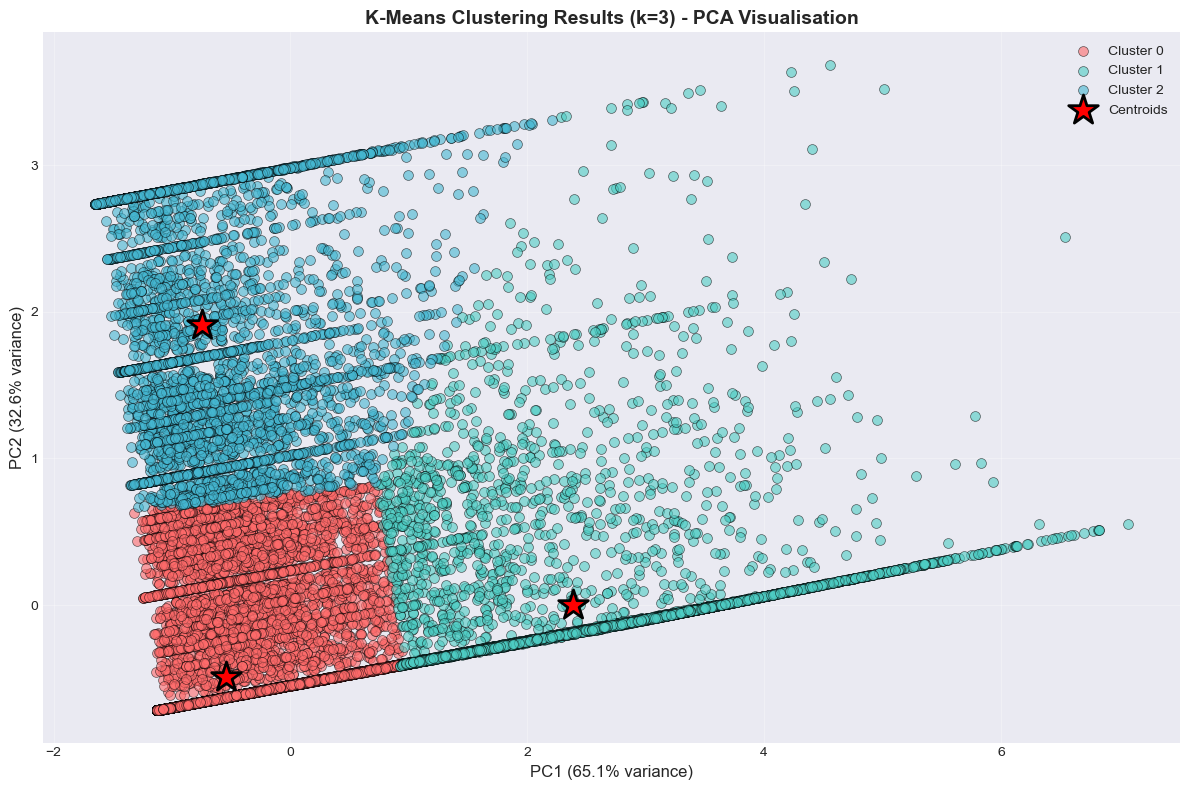

In [6]:
print('\n' + '=' * 80)
print('PCA DIMENSIONALITY REDUCTION')
print('=' * 80)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering_scaled)

print(f'PCA Explained Variance Ratio: {pca.explained_variance_ratio_}')
print(f'Total Variance Explained: {pca.explained_variance_ratio_.sum():.4f}')

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = cluster_labels

# Transform centroids for visualisation
centroids_pca = pca.transform(kmeans_final.cluster_centers_)

# Create scatter plot
plt.figure(figsize=(12, 8))

colours = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
for i in range(optimal_k):
    mask = cluster_labels == i
    plt.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=colours[i % len(colours)],
        label=f'Cluster {i}',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='red', marker='*', s=500,
    label='Centroids',
    edgecolors='black',
    linewidth=2
)

colours_for_legend = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title(f'K-Means Clustering Results (k={optimal_k}) - PCA Visualisation', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 6: Cluster Profiling

Analyse cluster characteristics and create learning personas.


CLUSTER PROFILING AND INTERPRETATION

Cluster Profiles (Mean Feature Values):
         total_clicks_norm  days_active_norm  submit_delay_norm  \
cluster                                                           
0                   0.1070            0.0486             0.0222   
1                   0.1820            0.0870             0.5072   
2                   0.7562            0.3126             0.0378   

         num_late_subs_norm  
cluster                      
0                    0.0497  
1                    0.6548  
2                    0.2112  


Detailed Learning Personas:

CLUSTER 0: Low Engagement | Brief/Sporadic | Very Punctual
   Population: 18036 students (55.3%)
   ─────────────────────────────────────────
   Engagement Level: Low Engagement (10.7%)
   Activity Duration: Brief/Sporadic (4.9% of course days)
   Submission Timeliness: Very Punctual (procrastination=2.2%)
   Late Submissions: 5.0% of norm
   Key Strengths: excellent time management; minimal late subm

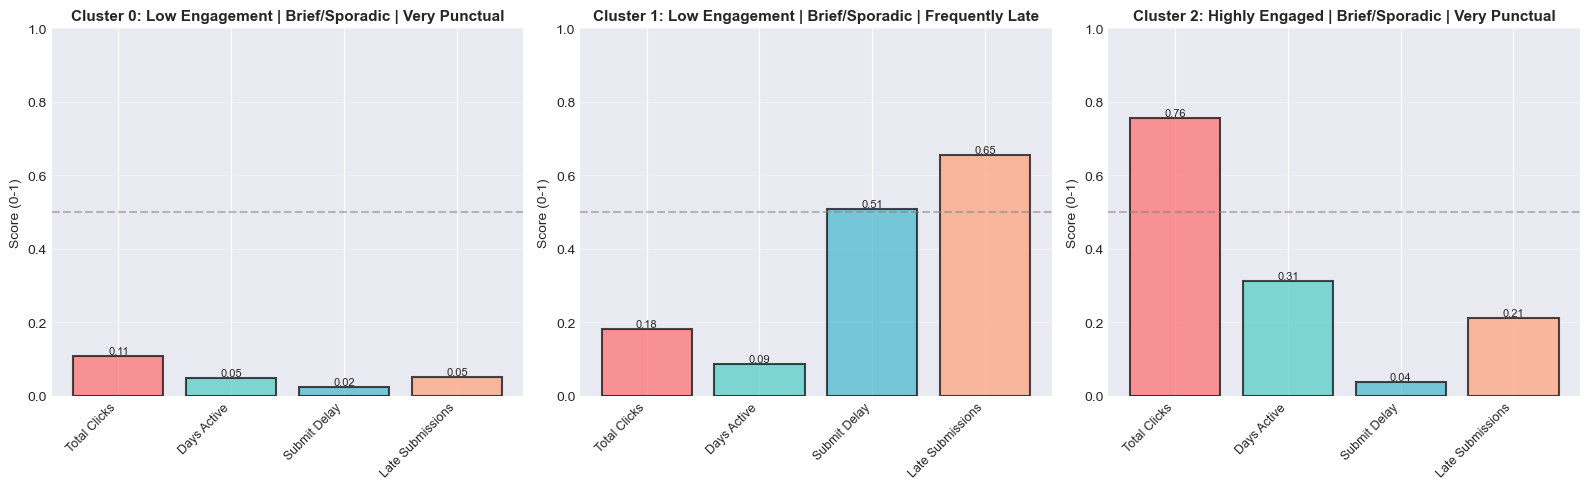

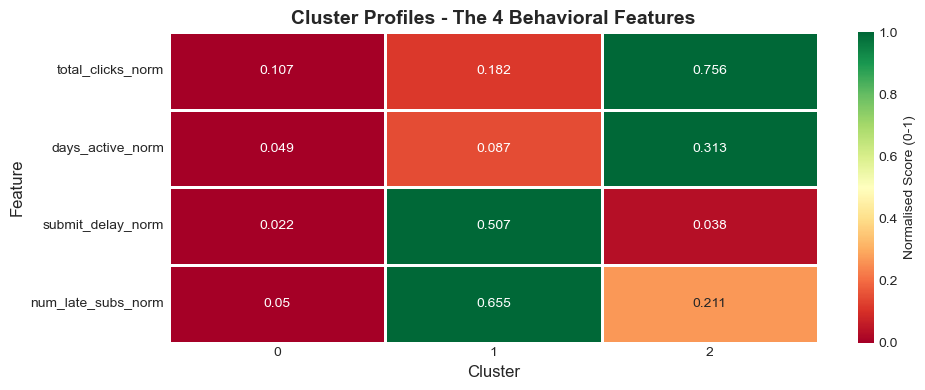


Clustering results saved for final notebook


In [12]:
print('\n' + '=' * 80)
print('CLUSTER PROFILING AND INTERPRETATION')
print('=' * 80)

# Add cluster labels to feature set for profiling
df_features['cluster'] = cluster_labels
cluster_profiles = df_features.groupby('cluster')[clustering_features].mean()

print('\nCluster Profiles (Mean Feature Values):')
print('=' * 80)
print(cluster_profiles.round(4))

# Create comprehensive learning personas
cluster_personas = {}
for cluster_id in range(optimal_k):
    profile = cluster_profiles.loc[cluster_id]
    
    # Direct feature values (already 0-1 normalized)
    # Map the 4 behavioral features to interpretable dimensions
    engagement = profile['total_clicks_norm']  # Engagement level
    activity_duration = profile['days_active_norm']  # Consistency/Activity span
    procrastination = profile['submit_delay_norm']  # Procrastination tendency (inverse of timeliness)
    late_subs = profile['num_late_subs_norm']  # Late submission frequency
    
    # Categorise engagement levels (3-tier)
    if engagement >= 0.67:
        engagement_level = 'Highly Engaged'
    elif engagement >= 0.33:
        engagement_level = 'Moderately Engaged'
    else:
        engagement_level = 'Low Engagement'
    
    # Categorise activity duration (3-tier)
    if activity_duration >= 0.67:
        activity_label = 'Sustained Throughout'
    elif activity_duration >= 0.33:
        activity_label = 'Moderate Duration'
    else:
        activity_label = 'Brief/Sporadic'
    
    # Categorise procrastination (inverse: high value = high procrastination = poor timeliness)
    if procrastination <= 0.2:
        timeliness_label = 'Very Punctual'
    elif procrastination <= 0.4:
        timeliness_label = 'Usually On-Time'
    elif procrastination <= 0.6:
        timeliness_label = 'Frequently Late'
    else:
        timeliness_label = 'Chronic Procrastinator'
    
    # Identify risk factors
    risk_factors = []
    if engagement < 0.4:
        risk_factors.append('low platform engagement')
    if activity_duration < 0.4:
        risk_factors.append('sporadic participation')
    if procrastination > 0.6:
        risk_factors.append('chronic procrastination')
    if late_subs > 0.5:
        risk_factors.append('frequent late submissions')
    
    # Identify strengths
    strengths = []
    if engagement >= 0.65:
        strengths.append('highly engaged with materials')
    if activity_duration >= 0.65:
        strengths.append('sustained course participation')
    if procrastination <= 0.3:
        strengths.append('excellent time management')
    if late_subs <= 0.2:
        strengths.append('minimal late submissions')
    
    # Create persona name
    persona_name = f'{engagement_level} | {activity_label} | {timeliness_label}'
    
    cluster_personas[cluster_id] = {
        'name': persona_name,
        'engagement_level': engagement_level,
        'activity_label': activity_label,
        'timeliness': timeliness_label,
        'engagement': engagement,
        'activity_duration': activity_duration,
        'procrastination': procrastination,
        'late_subs': late_subs,
        'risk_factors': risk_factors,
        'strengths': strengths
    }

print('\n\nDetailed Learning Personas:')
print('=' * 80)
for cluster_id, persona in cluster_personas.items():
    count = (cluster_labels == cluster_id).sum()
    pct = count / len(cluster_labels) * 100
    print(f'\nCLUSTER {cluster_id}: {persona["name"]}')
    print(f'   Population: {count} students ({pct:.1f}%)')
    print(f'   ─────────────────────────────────────────')
    print(f'   Engagement Level: {persona["engagement_level"]} ({persona["engagement"]:.1%})')
    print(f'   Activity Duration: {persona["activity_label"]} ({persona["activity_duration"]:.1%} of course days)')
    print(f'   Submission Timeliness: {persona["timeliness"]} (procrastination={persona["procrastination"]:.1%})')
    print(f'   Late Submissions: {persona["late_subs"]:.1%} of norm')
    
    if persona['strengths']:
        print(f'   Key Strengths: {"; ".join(persona["strengths"])}')
    
    if persona['risk_factors']:
        print(f'   Intervention Needed: {"; ".join(persona["risk_factors"])}')
    
    print(f'   Support Level: ', end='')
    if len(persona['risk_factors']) > 2:
        print(f'HIGH PRIORITY ({len(persona["risk_factors"])} risk factors)')
    elif persona['risk_factors']:
        print(f'MEDIUM PRIORITY ({len(persona["risk_factors"])} risk factor)')
    elif persona['engagement'] >= 0.65:
        print('MINIMAL (highly engaged)')
    else:
        print('MEDIUM PRIORITY (monitor progress)')

# Create persona comparison bar chart
print('\n' + '=' * 80)
print('PERSONA CHARACTERISTIC COMPARISON')
print('=' * 80)

# Prepare data for comparison (using the 4 engineered features)
comparison_metrics = ['Total Clicks', 'Days Active', 'Submit Delay', 'Late Submissions']

# Create subplots based on number of clusters
if optimal_k == 2:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
elif optimal_k == 3:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
elif optimal_k == 4:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
elif optimal_k == 5:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
else:
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten()

for idx, cluster_id in enumerate(range(optimal_k)):
    persona = cluster_personas[cluster_id]
    
    # Use the 4 normalized features
    metrics = [
        persona['engagement'],
        persona['activity_duration'],
        persona['procrastination'],
        persona['late_subs']
    ]
    
    ax = axes[idx]
    x_pos = np.arange(len(comparison_metrics))
    colours_bars = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    
    bars = ax.bar(x_pos, metrics, color=colours_bars, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score (0-1)', fontsize=10)
    ax.set_title(f'Cluster {cluster_id}: {persona["name"]}', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_metrics, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, color='grey', linestyle='--', alpha=0.5, label='Median')
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, metric in zip(bars, metrics):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{metric:.2f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Visualise cluster profiles with heatmap
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(
    cluster_profiles_normalized.T,
    annot=cluster_profiles.T.round(3),
    fmt='g',
    cmap='RdYlGn',
    cbar_kws={'label': 'Normalised Score (0-1)'},
    ax=ax,
    linewidths=1
)

ax.set_title('Cluster Profiles - The 4 Behavioral Features', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Save clustering results
import pickle
pickle.dump(kmeans_final, open('../2_Outputs/kmeans_model.pkl', 'wb'))
pickle.dump(cluster_labels, open('../2_Outputs/cluster_labels.pkl', 'wb'))
df_features['cluster'] = cluster_labels
df_features.to_pickle('../2_Outputs/df_with_clusters.pkl')

print('\nClustering results saved for final notebook')